# Loading The Libraries

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('Football').getOrCreate()

In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True)
import plotly.graph_objs as go
from pyspark.sql.types import FloatType,IntegerType,StringType
from pyspark.sql.functions import udf,mean,max
%matplotlib inline
sns.set()

# Data Processing

In [4]:
df=spark.read.csv('data.csv',header=True,inferSchema=True)
df.show(n=2, truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------
 _c0                      | 0                                              
 ID                       | 158023                                         
 Name                     | L. Messi                                       
 Age                      | 31                                             
 Photo                    | https://cdn.sofifa.org/players/4/19/158023.png 
 Nationality              | Argentina                                      
 Flag                     | https://cdn.sofifa.org/flags/52.png            
 Overall                  | 94                                             
 Potential                | 94                                             
 Club                     | FC Barcelona                                   
 Club Logo                | https://cdn.sofifa.org/teams/2/light/241.png   
 Value                    | €110.5M                                        
 Wage       

In [5]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- Wage: string (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nu

In [6]:
print('Rows:',df.count(),", Columns:",len(df.columns))

Rows: 18207 , Columns: 89


In [7]:
cols=df.columns
l=[]
for col in cols:
    x=df.filter(df[col].isNull()).count()
    if(x>0):
        print(col,':',x)
        l.append(col)

Club : 241
Preferred Foot : 48
International Reputation : 48
Weak Foot : 48
Skill Moves : 48
Work Rate : 48
Body Type : 48
Real Face : 48
Position : 60
Jersey Number : 60
Joined : 1553
Loaned From : 16943
Contract Valid Until : 289
Height : 48
Weight : 48
LS : 2085
ST : 2085
RS : 2085
LW : 2085
LF : 2085
CF : 2085
RF : 2085
RW : 2085
LAM : 2085
CAM : 2085
RAM : 2085
LM : 2085
LCM : 2085
CM : 2085
RCM : 2085
RM : 2085
LWB : 2085
LDM : 2085
CDM : 2085
RDM : 2085
RWB : 2085
LB : 2085
LCB : 2085
CB : 2085
RCB : 2085
RB : 2085
Crossing : 48
Finishing : 48
HeadingAccuracy : 48
ShortPassing : 48
Volleys : 48
Dribbling : 48
Curve : 48
FKAccuracy : 48
LongPassing : 48
BallControl : 48
Acceleration : 48
SprintSpeed : 48
Agility : 48
Reactions : 48
Balance : 48
ShotPower : 48
Jumping : 48
Stamina : 48
Strength : 48
LongShots : 48
Aggression : 48
Interceptions : 48
Positioning : 48
Vision : 48
Penalties : 48
Composure : 48
Marking : 48
StandingTackle : 48
SlidingTackle : 48
GKDiving : 48
GKHandlin

In [8]:
def get_dtype(df,colname):
    return [dtype for name, dtype in df.dtypes if name == colname][0]

for col in l:
    
    col_type = get_dtype(df,col)
    
    if(col_type == 'int'):
        
        df=df.fillna(df.select(mean(df[col])).collect()[0][0],[col])

df=df.na.fill("200lbs",['Weight'])
df=df.na.fill("5'11",['Height'])
df=df.na.fill('None',['Loaned From'])
df=df.na.fill('Jul 1, 2018',['Joined'])
df=df.na.fill('Normal',['Body Type'])
df=df.na.fill('No Info',['Position'])
df=df.na.fill('No Info',['Club'])
df=df.na.fill('Medium/ Medium',['Work Rate'])
df=df.na.fill('Right',['Preferred Foot']) 
df=df.na.fill(0)
df=df.na.fill('0')

In [63]:
def func_val(val):
    
    if('M' in val):
        val_=val[1:-1]
        val_=float(val_)
            
    elif('K' in val):
        val_=val[1:-1]
        val_=float(val_)
        val_=val_/1000
        
    elif(val=='€0'):
        val_=0
        
    else:
        val_=val
    
    return val_

val_ch1 = udf(lambda z: func_val(z), FloatType())
spark.udf.register("val_ch1", val_ch1)
df=df.withColumn('Value',val_ch1('Value'))

In [90]:
def func_wage(val):
   
    if('K' in val):
        val_=val[1:-1]
        val_=float(val_)
        
    elif(val=='€0'):
        val_=0
    
    else:
        val_=val
    
    return val_

val_ch2 = udf(lambda z: func_wage(z), FloatType())
spark.udf.register("val_ch2", val_ch2)
df=df.withColumn('Wage',val_ch2('Wage'))

In [91]:
def func_clause(val):
   
    if(val==0): 
        
        val_=val
    
    if('M' in val):
        val_=val[1:-1]
        val_=float(val_)
        
    elif('K' in val):
        val_=val[1:-1]
        val_=float(val_)
        val_=val_/1000
        
    elif(val=='€0'):
        val_=0
    
    else:
        val_=val
        
    return val_

val_ch3 = udf(lambda z: func_clause(z), FloatType())
spark.udf.register("val_ch3", val_ch3)
df=df.withColumn('Release Clause',val_ch3('Release Clause'))

In [92]:
def func_height(val):
   
    x=val.split("'")
    
    if(len(x)==2):
        
        h_ft = float(x[0])
        h_inch = float(x[1])

        h_inch += h_ft * 12
        h_cm = round(h_inch * 2.54, 1)
        
        val_=h_cm
    
    else:
        
        val_=val
    
    return val_

val_ch4 = udf(lambda z: func_height(z), FloatType())
spark.udf.register("val_ch4", val_ch4)
df=df.withColumn('Height',val_ch4('Height'))

In [93]:
def func_weight(val):
    val_=val[:-3]
    return val_

val_ch5 = udf(lambda z: func_weight(z), StringType())
spark.udf.register("val_ch5", val_ch5)
df=df.withColumn('Weight',val_ch5('Weight'))

# EDA

## Based on Overall Data

### Youngest And Oldest Players

In [14]:
df.orderBy(df["Age"]).select('Name','Age','Nationality','Club').show(n=10)

+---------------+---+-------------+-------------------+
|           Name|Age|  Nationality|               Club|
+---------------+---+-------------+-------------------+
|       A. Doğan| 16|       Turkey|        Kayserispor|
|       B. Waine| 16|  New Zealand| Wellington Phoenix|
|     C. Bassett| 16|United States|    Colorado Rapids|
|P. Samiec-Talar| 16|       Poland|      Śląsk Wrocław|
|    L. D'Arrigo| 16|    Australia|    Adelaide United|
|      B. Nygren| 16|       Sweden|       IFK Göteborg|
|       K. Broda| 16|       Poland|       Wisła Kraków|
|       R. Gómez| 16|    Argentina|Belgrano de Córdoba|
|      J. Olstad| 16|       Norway|    Sarpsborg 08 FF|
|       E. Ceide| 16|       Norway|       Rosenborg BK|
+---------------+---+-------------+-------------------+
only showing top 10 rows



In [15]:
df.orderBy(df["Age"].desc()).select('Name','Age','Nationality','Club').show(n=10)

+-------------+---+-----------------+--------------------+
|         Name|Age|      Nationality|                Club|
+-------------+---+-----------------+--------------------+
|     O. Pérez| 45|           Mexico|             Pachuca|
|    T. Warner| 44|Trinidad & Tobago|  Accrington Stanley|
|K. Pilkington| 44|          England|    Cambridge United|
|  S. Narazaki| 42|            Japan|      Nagoya Grampus|
|    J. Villar| 41|         Paraguay|             No Info|
|     B. Nivet| 41|           France|        ESTAC Troyes|
|     M. Tyler| 41|          England| Peterborough United|
| H. Sulaimani| 41|     Saudi Arabia|           Ohod Club|
|     C. Muñoz| 41|        Argentina|CD Universidad de...|
|  S. Phillips| 40|          England|         Yeovil Town|
+-------------+---+-----------------+--------------------+
only showing top 10 rows



### Highest Rated Players

In [16]:
x=df.orderBy(df["Overall"].desc()).select('Name','Overall','Nationality','Club')
x.show(n=20)

+-----------------+-------+-----------+-------------------+
|             Name|Overall|Nationality|               Club|
+-----------------+-------+-----------+-------------------+
|Cristiano Ronaldo|     94|   Portugal|           Juventus|
|         L. Messi|     94|  Argentina|       FC Barcelona|
|        Neymar Jr|     92|     Brazil|Paris Saint-Germain|
|     Sergio Ramos|     91|      Spain|        Real Madrid|
|        E. Hazard|     91|    Belgium|            Chelsea|
|        L. Modrić|     91|    Croatia|        Real Madrid|
|        L. Suárez|     91|    Uruguay|       FC Barcelona|
|     K. De Bruyne|     91|    Belgium|    Manchester City|
|           De Gea|     91|      Spain|  Manchester United|
|   R. Lewandowski|     90|     Poland|  FC Bayern München|
|      David Silva|     90|      Spain|    Manchester City|
|         J. Oblak|     90|   Slovenia|    Atlético Madrid|
|         T. Kroos|     90|    Germany|        Real Madrid|
|         D. Godín|     90|    Uruguay| 

In [17]:
data=[
    go.Scatter(
    x=list(x.select('Name').toPandas()['Name'])[:20],
    y=list(x.select('Overall').toPandas()['Overall'])[:20],
    mode='markers+lines'
    )
]

layout=go.Layout(
title='Highest Overall Player Rating',
xaxis=dict(title='Players'),
yaxis=dict(title='Rating'),
hovermode='closest'
)

fig = go.Figure(data=data,layout=layout)
iplot(fig)

### Players Rating vs Potential

In [18]:
x=df.orderBy(df["Overall"].desc()).select('Name','Overall','Nationality','Club','Potential')
x.show(n=20)

+-----------------+-------+-----------+-------------------+---------+
|             Name|Overall|Nationality|               Club|Potential|
+-----------------+-------+-----------+-------------------+---------+
|Cristiano Ronaldo|     94|   Portugal|           Juventus|       94|
|         L. Messi|     94|  Argentina|       FC Barcelona|       94|
|        Neymar Jr|     92|     Brazil|Paris Saint-Germain|       93|
|     Sergio Ramos|     91|      Spain|        Real Madrid|       91|
|        E. Hazard|     91|    Belgium|            Chelsea|       91|
|        L. Modrić|     91|    Croatia|        Real Madrid|       91|
|        L. Suárez|     91|    Uruguay|       FC Barcelona|       91|
|     K. De Bruyne|     91|    Belgium|    Manchester City|       92|
|           De Gea|     91|      Spain|  Manchester United|       93|
|   R. Lewandowski|     90|     Poland|  FC Bayern München|       90|
|      David Silva|     90|      Spain|    Manchester City|       90|
|         J. Oblak| 

In [19]:
trace0=go.Scatter(
    x=list(x.select('Name').toPandas()['Name'])[:20],
    y=list(x.select('Overall').toPandas()['Overall'])[:20],
    mode='markers+lines',
    name='Overall Rating',
    marker=dict(size=14,color='rgb(0,100,0)',line=dict(width=2)))

trace1=go.Scatter(
   x=list(x.select('Name').toPandas()['Name'])[:20],
    y=list(x.select('Potential').toPandas()['Potential'])[:20],
    mode='markers+lines',
    name='Potential Rating',
    marker=dict(size=14,color='rgb(100,0,0)',line=dict(width=2)))


data=[trace0,trace1]

layout=go.Layout(
title='Overall vs Potential',
xaxis=dict(title='Players'),
yaxis=dict(title='Rating'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Players with Highest Growth

In [20]:
x=df.withColumn('Growth',(df['Potential']-df['Overall']).cast('int')).select('Name','Overall','Potential','Growth')
x=x.orderBy(x['Growth'].desc())

trace0=go.Bar(
    x=list(x.select('Name').toPandas()['Name'])[:20],
    y=list(x.select('Overall').toPandas()['Overall'])[:20],
    name='Overall Rating')

trace1=go.Bar(
   x=list(x.select('Name').toPandas()['Name'])[:20],
    y=list(x.select('Growth').toPandas()['Growth'])[:20],
    name='Growth')


data=[trace0,trace1]

layout=go.Layout(
title='Growth',barmode='stack',
xaxis=dict(title='Foot'),
yaxis=dict(title='Weak Foot Value/Skills Value'),
hovermode='closest')
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### How does Potential Changes Over Age

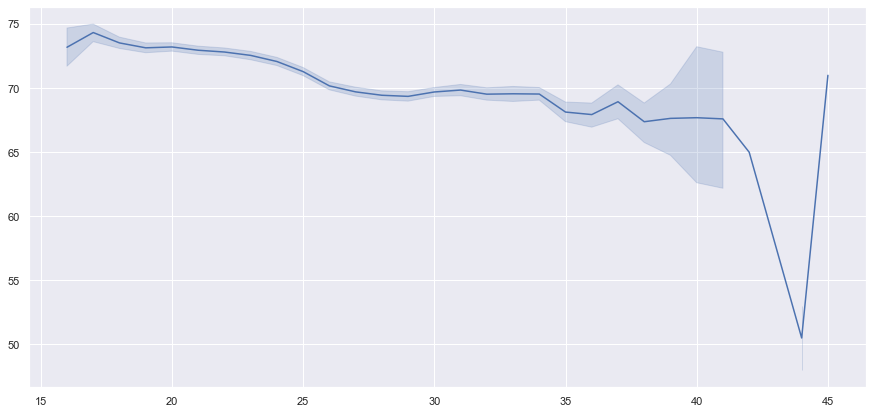

In [21]:
plt.figure(figsize=(15,7))
sns.lineplot(list(df.select('Age').toPandas()['Age']),list(df.select('Potential').toPandas()['Potential']))

### Age Vs Rating

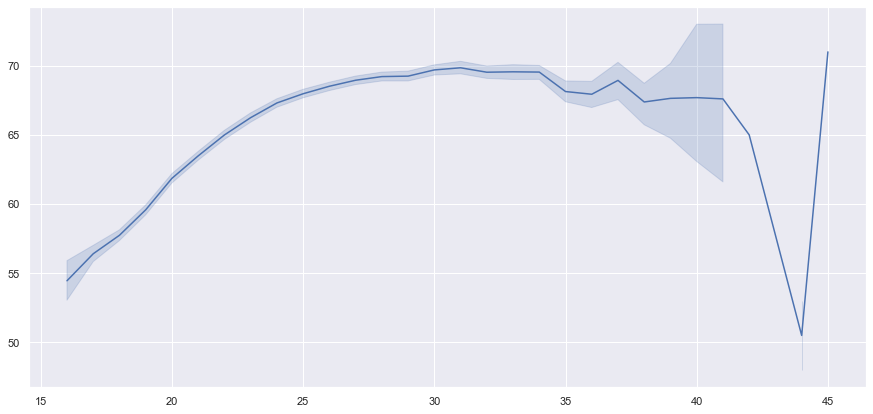

In [22]:
plt.figure(figsize=(15,7))
sns.lineplot(list(df.select('Age').toPandas()['Age']),list(df.select('Overall').toPandas()['Overall']))

### Countries with Youngest and Oldest Talents

#### Oldest

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

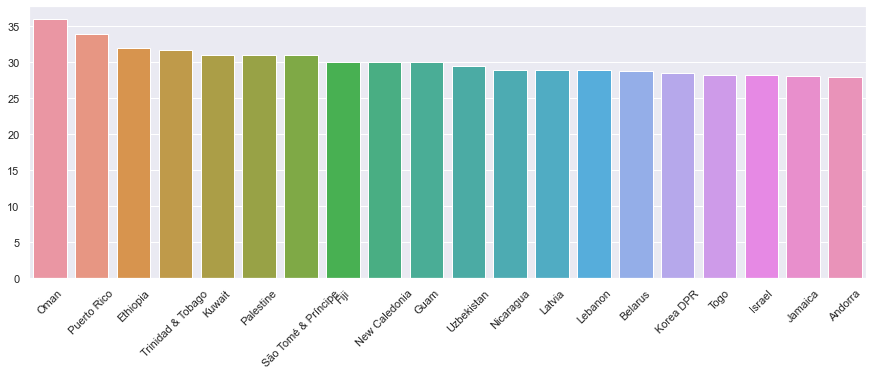

In [23]:
x=df.groupby('Nationality').agg({"Age":'mean'})
x=x.orderBy(x['avg(Age)'].desc())
plt.figure(figsize=(15,5))
sns.barplot(list(x.select('Nationality').toPandas()['Nationality'])[:20],list(x.select('avg(Age)').toPandas()['avg(Age)'][:20]))
plt.xticks(rotation=45)

#### Youngest

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

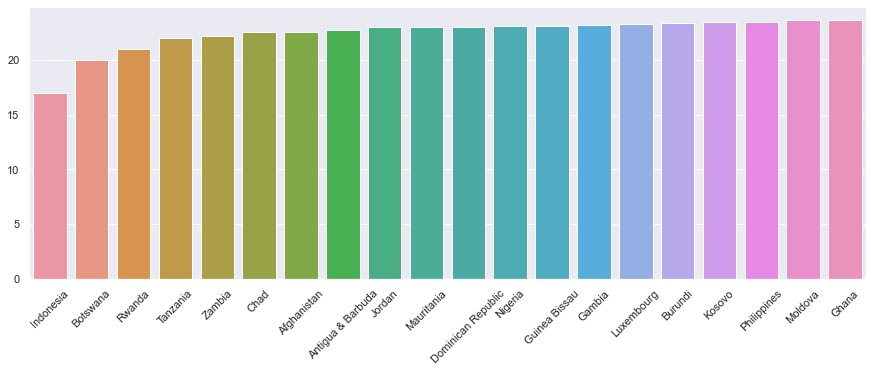

In [24]:
x=df.groupby('Nationality').agg({"Age":'mean'})
x=x.orderBy(x['avg(Age)'])
plt.figure(figsize=(15,5))
sns.barplot(list(x.select('Nationality').toPandas()['Nationality'])[:20],list(x.select('avg(Age)').toPandas()['avg(Age)'][:20]))
plt.xticks(rotation=45)

### Club wtih Most Valuable Players 

In [164]:
x=df.groupby('Club').agg({'Value':'sum'})
x=x.orderBy(x['sum(Value)'].desc())

data=[
    go.Scatter(
    x=list(x.select('Club').toPandas()['Club'])[:20],
    y=list(x.select('sum(Value)').toPandas()['sum(Value)'])[:20],
    mode='markers+lines'
    )
]

layout=go.Layout(
title='Club with Most Valuable Player',
xaxis=dict(title='Clubs'),
yaxis=dict(title='Value in Million'),
hovermode='closest'
)

fig = go.Figure(data=data,layout=layout)
iplot(fig)

### Clubs Offering Highest Wages

In [26]:
x=df.groupby('Club').agg({'Wage':'sum'})
x=x.orderBy(x['sum(Wage)'].desc())

data=[
    go.Scatter(
    x=list(x.select('Club').toPandas()['Club'])[:20],
    y=list(x.select('sum(Wage)').toPandas()['sum(Wage)'])[:20],
    mode='markers+lines'
    )
]

layout=go.Layout(
title='Clubs Offering Highest Wages',
xaxis=dict(title='Clubs'),
yaxis=dict(title='Value in Million'),
hovermode='closest'
)

fig = go.Figure(data=data,layout=layout)
iplot(fig)

### Club With Best Players

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

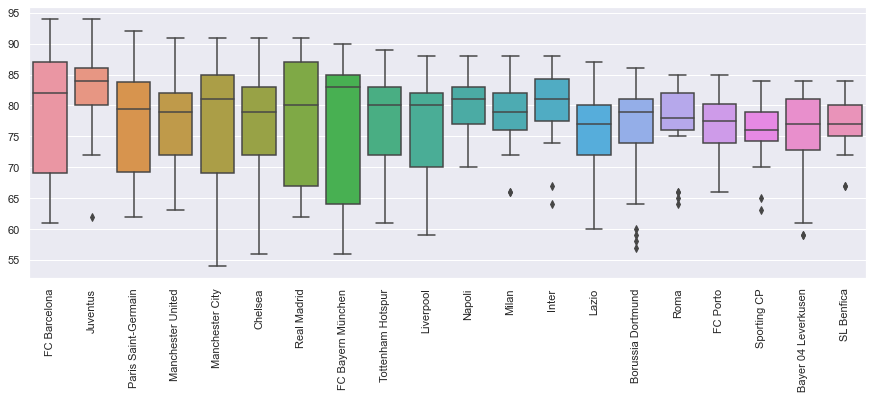

In [27]:
x=df.groupby('Club').agg({'Overall':'mean'})
x=x.orderBy(x['avg(Overall)'].desc())
x1=list(x.select('Club').toPandas()['Club'])[:20]

def func_pl(val):
    if(val in x1):
        val_=1
    else:
        val_=0
    
    return val_

val_ch7 = udf(lambda z: func_pl(z), IntegerType())
spark.udf.register("val_ch7", val_ch7)
x=df.withColumn('Club Elite',val_ch7('Club')).select('Club','Club Elite','Overall')
x=x.filter(x['Club Elite']==1).select('Club','Overall')


plt.figure(figsize=(15,5))
sns.boxplot(list(x.select('Club').toPandas()['Club']),list(x.select('Overall').toPandas()['Overall']))
plt.xticks(rotation=90)

### Club with Most World Class Players (Above 85 Rating)

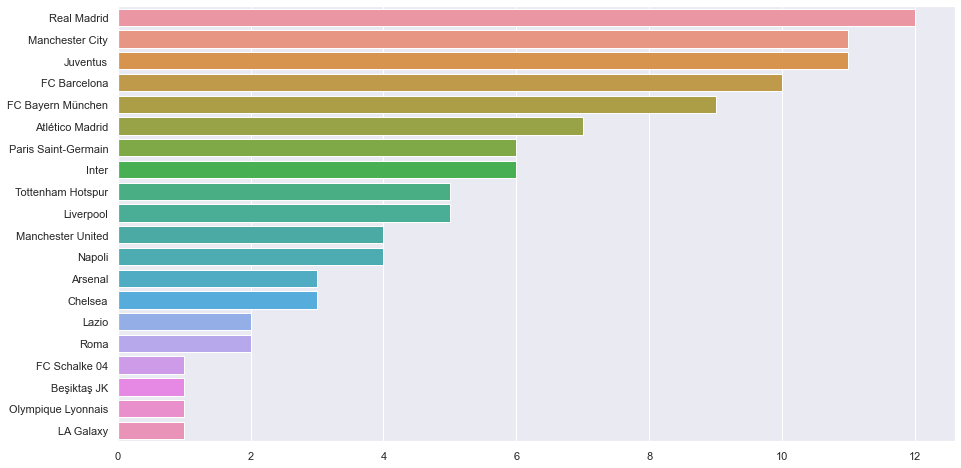

In [28]:
x=df.filter(df['Overall']>=85).select('Club')
x=x.groupby('Club').agg({'Club':'count'})
x=x.orderBy(x['count(Club)'].desc())

plt.figure(figsize=(15,8))
sns.barplot(list(x.select('count(Club)').toPandas()['count(Club)'])[:20],list(x.select('Club').toPandas()['Club'])[:20])

### Most Preferred Foot

In [29]:
x=df.groupby('Preferred Foot').agg({'Preferred Foot':'count'})

data=[go.Pie(
        labels=list(x.select('Preferred Foot').toPandas()['Preferred Foot']),
        values=list(x.select('count(Preferred Foot)').toPandas()['count(Preferred Foot)'])
)]

layout=go.Layout(
title='Most Preferred Foot',
xaxis=dict(title='Foot'),
yaxis=dict(title='Count'),
hovermode='closest'
)

fig = go.Figure(data=data,layout=layout)
iplot(fig)

### Which Foot Player have better skills and Weak Foot

In [30]:
x=df.groupby('Preferred Foot').agg({'Weak Foot':'mean','Skill Moves':'mean'})

trace0=go.Bar(
    x=list(x.select('Preferred Foot').toPandas()['Preferred Foot']),
    y=list(x.select('avg(Skill Moves)').toPandas()['avg(Skill Moves)']),
    text='Skill Moves Value',
    name='Skill Moves Value',
    )

trace1=go.Bar(
    x=list(x.select('Preferred Foot').toPandas()['Preferred Foot']),
    y=list(x.select('avg(Weak Foot)').toPandas()['avg(Weak Foot)']),
    text='Weak Foot Value',
    name='Weak Foot Value',
    )

data=[trace0,trace1]

layout=go.Layout(
title='Which Foot Player have better skills and Weak Foot',barmode='stack',
xaxis=dict(title='Foot'),
yaxis=dict(title='Weak Foot Value/Skills Value'),
hovermode='closest')
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### How Players work rate affect their rating

In [31]:
x=df.groupby('Work Rate').agg({'Overall':'mean','Potential':'mean'})

trace0=go.Scatter(
    x=list(x.select('Work Rate').toPandas()['Work Rate']),
    y=list(x.select('avg(Overall)').toPandas()['avg(Overall)']),
    name='Overall',
    mode='markers+lines',
    marker=dict(size=14,color='rgb(0,100,0)',line=dict(width=2))
    )

trace1=go.Scatter(
    x=list(x.select('Work Rate').toPandas()['Work Rate']),
    y=list(x.select('avg(Potential)').toPandas()['avg(Potential)']),
    name='Potential',
    mode='markers+lines',
    marker=dict(size=14,color='rgb(100,0,0)',line=dict(width=2))
    )

data=[trace0,trace1]

layout=go.Layout(
title='Work Rate vs Rating',
xaxis=dict(title='Work Rate'),
yaxis=dict(title='Rating'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Work Rate vs Player Skills

In [32]:
x=df.groupby('Work Rate').agg({'Skill Moves':'mean'})

data=go.Bar(
    x=list(x.select('Work Rate').toPandas()['Work Rate']),
    y=list(x.select('avg(Skill Moves)').toPandas()['avg(Skill Moves)']),
    name='Skill Moves')



layout=go.Layout(
title='Work Rate vs Skills',
xaxis=dict(title='Work Rate'),
yaxis=dict(title='Skills Value'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### How good are the reputed players

Text(0.5, 1.0, 'Potential vs International Reputation')

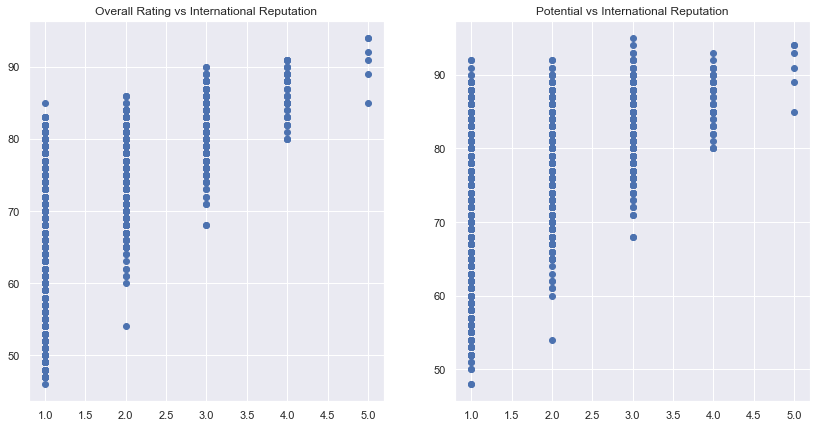

In [33]:
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(14,7))

ax1.scatter(list(df.select('International Reputation').toPandas()['International Reputation']),list(df.select('Overall').toPandas()['Overall']))
ax2.scatter(list(df.select('International Reputation').toPandas()['International Reputation']),list(df.select('Potential').toPandas()['Potential']))

ax1.set_title('Overall Rating vs International Reputation')
ax2.set_title('Potential vs International Reputation')

### Club With Most Reputed Players

In [34]:
x=df.groupby('Club').agg({'International Reputation':'mean'})
x=x.orderBy(x['avg(International Reputation)'].desc())
data=go.Bar(
    x=list(x.select('Club').toPandas()['Club'])[:20],
    y=list(x.select('avg(International Reputation)').toPandas()['avg(International Reputation)'])[:20],
    name='International Reputation Rating')



layout=go.Layout(
title='Clubs with most Reputed Players ',
xaxis=dict(title='Clubs'),
yaxis=dict(title='Reputation'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Age VS Value

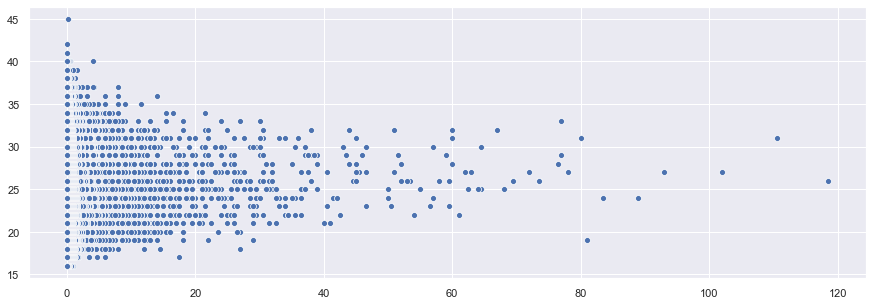

In [165]:
df_temp=df.select('Age','Value')
plt.figure(figsize=(15,5))
sns.scatterplot(list(df_temp.select('Value').toPandas()['Value']),list(df_temp.select('Age').toPandas()['Age']))

In [36]:
df_temp=df.select('Age','Value')

def func_age(age):
    
    if(age<20):
        val_='Below 20'
    elif((age>20)&(age<25)):
        val_='Between 20 And 25'
    elif((age>25)&(age<30)):
        val_='Between 25 And 30'
    elif((age>30)&(age<35)):
        val_='Between 30 And 35'
    else:
        val_='Above 35'

    return val_

val_ch8 = udf(lambda z: func_age(z), StringType())
spark.udf.register("val_ch8", val_ch8)
x=df_temp.withColumn('Age_cat',val_ch8('Age')).select('Age_cat')

val_ch1 = udf(lambda z: func_val(z), FloatType())
spark.udf.register("val_ch1", val_ch1)
x1=df_temp.withColumn('Value',val_ch1('Value')).select('Value')

In [37]:
data=go.Box(
    x=list(x.select('Age_cat').toPandas()['Age_cat']),
    y=list(x1.select('Value').toPandas()['Value']),
    name='Value')

layout=go.Layout(
title='Distribution of Player Value By Age',
xaxis=dict(title='Age'),
yaxis=dict(title='Value in Millions'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Player Rating vs Value

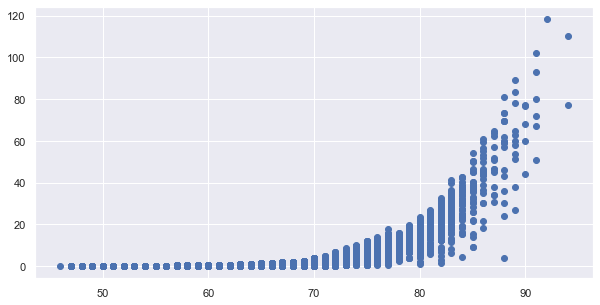

In [166]:
df_temp=df.select('Overall','Value')
plt.figure(figsize=(10,5))
plt.scatter(list(df_temp.select('Overall').toPandas()['Overall']),list(df_temp.select('Value').toPandas()['Value']))

### Distribution Of Player on basis on body type and their rating

In [39]:
x=df.groupby('Body Type').agg({'Body Type':'count'})
x=x.filter(x['count(Body Type)']>1)
data=[go.Pie(
        labels=list(x.select('Body Type').toPandas()['Body Type']),
        values=list(x.select('count(Body Type)').toPandas()['count(Body Type)']))]

layout=go.Layout(
title='Body Type',
xaxis=dict(title='Foot'),
yaxis=dict(title='Count'),
hovermode='closest'
)

fig = go.Figure(data=data,layout=layout)
iplot(fig)

### Player Count By Position

In [40]:
x=df.groupby('Position').agg({'Position':'count'})
x=x.filter(x['count(Position)']>1)
data=[go.Pie(
        labels=list(x.select('Position').toPandas()['Position']),
        values=list(x.select('count(Position)').toPandas()['count(Position)']))]

layout=go.Layout(
title='Position',
xaxis=dict(title='Foot'),
yaxis=dict(title='Count'),
hovermode='closest'
)

fig = go.Figure(data=data,layout=layout)
iplot(fig)

### Average Rating By Position

In [41]:
x=df.groupby('Position').agg({'Overall':'mean','Potential':'mean'})
x=x.orderBy(x['avg(Overall)'].desc())

data1=go.Bar(
    x=list(x.select('Position').toPandas()['Position']),
    y=list(x.select('avg(Overall)').toPandas()['avg(Overall)']),
    name='Overall Rating By Position')

data2=go.Bar(
    x=list(x.select('Position').toPandas()['Position']),
    y=list(x.select('avg(Potential)').toPandas()['avg(Potential)']),
    name='Potential Rating By Position')



data=[data1,data2]

layout=go.Layout(
title='Average Rating by Position',
xaxis=dict(title='Position'),
yaxis=dict(title='Rating'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Players Value by Position

In [167]:
df_temp=df.select('Position','Value')

data=go.Box(
    x=list(df_temp.select('Position').toPandas()['Position']),
    y=list(df_temp.select('Value').toPandas()['Value']))




layout=go.Layout(
title='Player Value By Position',
xaxis=dict(title='Position'),
yaxis=dict(title='Value in Millions'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Best Player By Position

In [43]:
x=df.groupby('Position').agg({'Overall':'max'})

name=[]
rating=[]
for i in range(x.count()):    
    y=x.collect()[i]['max(Overall)']
    w=x.collect()[i]['Position']
    record=df.filter((df['Overall']==y)&(df['Position']==w)).select('Name').collect()[0][0]
    record=record+' ['+w+"]"
    name.append(record)
    rating.append(y)    
    
data=[
    go.Scatter(
    x=name,
    y=rating,
    mode='markers+lines'
    )
]

layout=go.Layout(
title='Player with Best Rating By Position',
xaxis=dict(title='Player By Position'),
yaxis=dict(title='Rating'),
hovermode='closest'
)

fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [170]:
df_temp=df.select('Position','Value','Name')
x=df_temp.groupby('Position').agg({'Value':'max'})

name=[]
rating=[]
for i in range(x.count()):
    
    y=x.collect()[i]['max(Value)']
    w=x.collect()[i]['Position']
    record=df_temp.filter((df_temp['Value']==y)&(df_temp['Position']==w)).select('Name').collect()[0][0]
    record=record+' ['+w+"]"
    name.append(record)
    rating.append(y)    
    
data=[
    go.Scatter(
    x=name,
    y=rating,
    mode='markers+lines'
    )
]

layout=go.Layout(
title='Most Expensive Player By Position',
xaxis=dict(title='Player By Position'),
yaxis=dict(title='Value'),
hovermode='closest'
)

fig = go.Figure(data=data,layout=layout)
iplot(fig)

### Comparing Abilities of Players By Position 

In [61]:
attack=['RF', 'ST', 'LW','LF','RW','CF','RS','LS']
df_at=df.filter((df['Position']=='RF') | (df['Position']=='ST') | (df['Position']=='LW') | (df['Position']=='RW') |
                (df['Position']=='CF') | (df['Position']=='RS') | (df['Position']=='LS') | (df['Position']=='LF') )


mid=['RCM','LCM','LDM', 'CAM', 'CDM','RM', 'LAM', 'LM','RDM','CM','RAM']
df_mid=df.filter((df['Position']=='RCM') | (df['Position']=='LCM') | (df['Position']=='CAM') | (df['Position']=='CDM') |
                (df['Position']=='RM') | (df['Position']=='LAM') | (df['Position']=='LM') | (df['Position']=='RDM') | 
                (df['Position']=='CM') | (df['Position']=='RAM') )

defense=['RCB','CB','LCB','LB','RB','RWB', 'LWB']
df_def=df.filter((df['Position']=='RCB') | (df['Position']=='CB') | (df['Position']=='LCB') | (df['Position']=='LB') |
                (df['Position']=='RB') | (df['Position']=='RWB') | (df['Position']=='LWB'))


def position(val):
    
    if(val in attack):
        val_='Attack'
    elif(val in mid):
        val_='Midfield'
    elif(val in defense):
        val_='Defense'
    elif(val=='GK'):
        val_='GoalKeeper'
    else:
        val_='No Info'
    
    return val_
    

val_ch_pos = udf(lambda z: position(z), StringType())
spark.udf.register("val_ch_pos", val_ch_pos)
df=df.withColumn('Field Position',val_ch_pos('Position'))

In [68]:
df_temp=df.filter(df['Field Position']!='No Info')
data=go.Box(
    x=list(df_temp.select('Field Position').toPandas()['Field Position']),
    y=list(df_temp.select('Value').toPandas()['Value']))




layout=go.Layout(
title='Distribution of Player Value By Field Position',
xaxis=dict(title='Position'),
yaxis=dict(title='Value in Millions'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

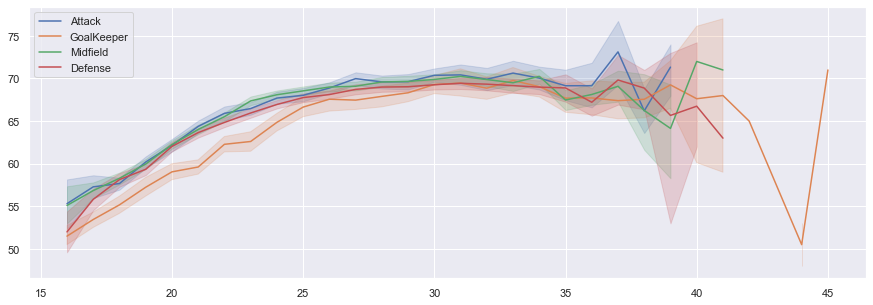

In [69]:
plt.figure(figsize=(15,5))
sns.lineplot(list(df_temp.select('Age').toPandas()['Age']),
             list(df_temp.select('Overall').toPandas()['Overall']),
             hue=list(df_temp.select('Field Position').toPandas()['Field Position']))

In [74]:
x=df.groupby('Field Position').agg({'Overall':'mean','Potential':'mean'})
x=x.filter(x['Field Position']!='No Info')

data0=go.Scatter(
    x=list(x.select('Field Position').toPandas()['Field Position']),
    y=list(x.select('avg(Overall)').toPandas()['avg(Overall)']),
    mode='markers+lines',
    name='Overall')


data1=go.Scatter(
    x=list(x.select('Field Position').toPandas()['Field Position']),
    y=list(x.select('avg(Potential)').toPandas()['avg(Potential)']),
    mode='markers+lines',
    name='Potential')


data=[data1,data0]

layout=go.Layout(
title='Average Rating By Section',
xaxis=dict(title='Position'),
yaxis=dict(title='Rating'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Attacking Abilitites

In [87]:
x=['Attack','Midfield','Defense']
y=[df_at.select(mean(df_at['Crossing'])).collect()[0][0],df_mid.select(mean(df_mid['Crossing'])).collect()[0][0],
   df_def.select(mean(df_def['Crossing'])).collect()[0][0]]
y1=[df_at.select(mean(df_at['Finishing'])).collect()[0][0],df_mid.select(mean(df_mid['Finishing'])).collect()[0][0],
   df_def.select(mean(df_def['Finishing'])).collect()[0][0]]
y2=[df_at.select(mean(df_at['HeadingAccuracy'])).collect()[0][0],df_mid.select(mean(df_mid['HeadingAccuracy'])).collect()[0][0],
   df_def.select(mean(df_def['HeadingAccuracy'])).collect()[0][0]]
y3=[df_at.select(mean(df_at['Volleys'])).collect()[0][0],df_mid.select(mean(df_mid['Volleys'])).collect()[0][0],
   df_def.select(mean(df_def['Volleys'])).collect()[0][0]]
y4=[df_at.select(mean(df_at['Dribbling'])).collect()[0][0],df_mid.select(mean(df_mid['Dribbling'])).collect()[0][0],
   df_def.select(mean(df_def['Dribbling'])).collect()[0][0]]
y5=[df_at.select(mean(df_at['Curve'])).collect()[0][0],df_mid.select(mean(df_mid['Curve'])).collect()[0][0],
   df_def.select(mean(df_def['Curve'])).collect()[0][0]]

data0=go.Bar(
    x=x,
    y=y,
    name='Crossing')


data1=go.Bar(
    x=x,
    y=y1,
    name='Finishing')

data2=go.Bar(
    x=x,
    y=y3,
    name='Volleys')

data3=go.Bar(
    x=x,
    y=y4,
    name='Dribbling')

data4=go.Bar(
    x=x,
    y=y5,
    name='Curve')

data5=go.Bar(
    x=x,
    y=y2,
    name='HeadingAccuracy')


data=[data1,data0,data2,data3,data4,data5]

layout=go.Layout(
title='Attacking Abilitites',
xaxis=dict(title='Position'),
yaxis=dict(title='Rating'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Midfield Abilitites

In [86]:
x=['Attack','Midfield','Defense']
y=[df_at.select(mean(df_at['ShortPassing'])).collect()[0][0],df_mid.select(mean(df_mid['ShortPassing'])).collect()[0][0],
   df_def.select(mean(df_def['ShortPassing'])).collect()[0][0]]
y1=[df_at.select(mean(df_at['LongPassing'])).collect()[0][0],df_mid.select(mean(df_mid['LongPassing'])).collect()[0][0],
   df_def.select(mean(df_def['LongPassing'])).collect()[0][0]]
y2=[df_at.select(mean(df_at['Vision'])).collect()[0][0],df_mid.select(mean(df_mid['Vision'])).collect()[0][0],
   df_def.select(mean(df_def['Vision'])).collect()[0][0]]

data0=go.Bar(
    x=x,
    y=y,
    name='ShortPassing')


data1=go.Bar(
    x=x,
    y=y1,
    name='LongPassing')

data2=go.Bar(
    x=x,
    y=y3,
    name='Vision')

data=[data1,data0,data2]

layout=go.Layout(
title='Midfield Abilitites',
xaxis=dict(title='Position'),
yaxis=dict(title='Rating'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Defensive Abilities

In [85]:
x=['Attack','Midfield','Defense']
y=[df_at.select(mean(df_at['Interceptions'])).collect()[0][0],df_mid.select(mean(df_mid['Interceptions'])).collect()[0][0],
   df_def.select(mean(df_def['Interceptions'])).collect()[0][0]]
y1=[df_at.select(mean(df_at['Marking'])).collect()[0][0],df_mid.select(mean(df_mid['Marking'])).collect()[0][0],
   df_def.select(mean(df_def['Marking'])).collect()[0][0]]
y2=[df_at.select(mean(df_at['StandingTackle'])).collect()[0][0],df_mid.select(mean(df_mid['StandingTackle'])).collect()[0][0],
   df_def.select(mean(df_def['StandingTackle'])).collect()[0][0]]
y3=[df_at.select(mean(df_at['SlidingTackle'])).collect()[0][0],df_mid.select(mean(df_mid['SlidingTackle'])).collect()[0][0],
   df_def.select(mean(df_def['SlidingTackle'])).collect()[0][0]]
y4=[df_at.select(mean(df_at['Composure'])).collect()[0][0],df_mid.select(mean(df_mid['Composure'])).collect()[0][0],
   df_def.select(mean(df_def['Composure'])).collect()[0][0]]
y5=[df_at.select(mean(df_at['Positioning'])).collect()[0][0],df_mid.select(mean(df_mid['Positioning'])).collect()[0][0],
   df_def.select(mean(df_def['Positioning'])).collect()[0][0]]

data0=go.Bar(
    x=x,
    y=y,
    name='Interceptions')


data1=go.Bar(
    x=x,
    y=y1,
    name='Marking')

data2=go.Bar(
    x=x,
    y=y2,
    name='StandingTackle')

data3=go.Bar(
    x=x,
    y=y3,
    name='SlidingTackle')

data4=go.Bar(
    x=x,
    y=y4,
    name='Composure')

data5=go.Bar(
    x=x,
    y=y5,
    name='Positioning')


data=[data1,data0,data2,data3,data4,data5]

layout=go.Layout(
title='Defensive Abilities',
xaxis=dict(title='Position'),
yaxis=dict(title='Rating'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### General Player Abilities 

In [89]:
x=['Attack','Midfield','Defense']
y=[df_at.select(mean(df_at['FKAccuracy'])).collect()[0][0],df_mid.select(mean(df_mid['FKAccuracy'])).collect()[0][0],
   df_def.select(mean(df_def['FKAccuracy'])).collect()[0][0]]
y1=[df_at.select(mean(df_at['SprintSpeed'])).collect()[0][0],df_mid.select(mean(df_mid['SprintSpeed'])).collect()[0][0],
   df_def.select(mean(df_def['SprintSpeed'])).collect()[0][0]]
y2=[df_at.select(mean(df_at['Acceleration'])).collect()[0][0],df_mid.select(mean(df_mid['Acceleration'])).collect()[0][0],
   df_def.select(mean(df_def['Acceleration'])).collect()[0][0]]
y3=[df_at.select(mean(df_at['Jumping'])).collect()[0][0],df_mid.select(mean(df_mid['Jumping'])).collect()[0][0],
   df_def.select(mean(df_def['Jumping'])).collect()[0][0]]
y4=[df_at.select(mean(df_at['Stamina'])).collect()[0][0],df_mid.select(mean(df_mid['Stamina'])).collect()[0][0],
   df_def.select(mean(df_def['Stamina'])).collect()[0][0]]
y5=[df_at.select(mean(df_at['Strength'])).collect()[0][0],df_mid.select(mean(df_mid['Strength'])).collect()[0][0],
   df_def.select(mean(df_def['Strength'])).collect()[0][0]]
y6=[df_at.select(mean(df_at['Penalties'])).collect()[0][0],df_mid.select(mean(df_mid['Penalties'])).collect()[0][0],
   df_def.select(mean(df_def['Penalties'])).collect()[0][0]]

data0=go.Bar(
    x=x,
    y=y,
    name='FKAccuracy')


data1=go.Bar(
    x=x,
    y=y1,
    name='SprintSpeed')

data2=go.Bar(
    x=x,
    y=y2,
    name='Acceleration')

data3=go.Bar(
    x=x,
    y=y3,
    name='Jumping')

data4=go.Bar(
    x=x,
    y=y4,
    name='Stamina')

data5=go.Bar(
    x=x,
    y=y5,
    name='Strength')

data6=go.Bar(
    x=x,
    y=y6,
    name='Penalties')



data=[data1,data0,data2,data3,data4,data5,data6]

layout=go.Layout(
title='General Abilitites',
xaxis=dict(title='Position'),
yaxis=dict(title='Rating'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Players With Highest Release Clause

In [100]:
x=df.orderBy(df['Release Clause'].desc()).select('Name','Release Clause')

data=[
    go.Scatter(
    x=list(x.select('Name').toPandas()['Name'])[:20],
    y=list(x.select('Release Clause').toPandas()['Release Clause'])[:20],
    mode='markers+lines'
    )
]

layout=go.Layout(
title='Players with Highest Release Clause',
xaxis=dict(title='Player'),
yaxis=dict(title='Value in Million'),
hovermode='closest'
)

fig = go.Figure(data=data,layout=layout)
iplot(fig)

### Average Release Clause By Postion

In [102]:
x=df.filter(df['Release Clause']>10)
x=x.groupby('Field Position').agg({'Release Clause':'mean'})

x=x.filter(x['Field Position']!='No Info')

data=go.Bar(
    x=list(x.select('Field Position').toPandas()['Field Position']),
    y=list(x.select('avg(Release Clause)').toPandas()['avg(Release Clause)']),
    name='Release Clause')

layout=go.Layout(
title='Average Release Clause By Position',
xaxis=dict(title='Position'),
yaxis=dict(title='Release Clause In Millions'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Best Attacking Players

In [107]:
df_at=df_at.withColumn('Overall Attacking',(df_at['Finishing']+df_at['HeadingAccuracy']+df_at['Volleys']+df_at['Dribbling']+df_at['Curve']+
                            df_at['ShotPower']+df_at['LongShots']+df_at['Acceleration']+df_at['Agility']+df['Strength'])/10)

df_at=df_at.orderBy(df_at['Overall Attacking'].desc())
data=go.Scatter(
    x=list(df_at.select('Name').toPandas()['Name'])[:20],
    y=list(df_at.select('Overall Attacking').toPandas()['Overall Attacking'])[:20],
    mode='markers+lines',
    name='Overall Attacking Rating')

layout=go.Layout(
title='Player with Best Attacking Ability',
xaxis=dict(title='Player'),
yaxis=dict(title='Rating'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Best Midfield Players

In [108]:
df_mid=df_mid.withColumn('Overall Mid',(df_mid['ShortPassing']+df_mid['LongPassing']+df_mid['BallControl']+df_mid['Dribbling']+df_mid['Vision']+
                        df_mid['Acceleration']+df_mid['Agility']+df_mid['Strength'])/8)

df_mid=df_mid.orderBy(df_mid['Overall Mid'].desc())
data=go.Scatter(
    x=list(df_mid.select('Name').toPandas()['Name'])[:20],
    y=list(df_mid.select('Overall Mid').toPandas()['Overall Mid'])[:20],
    mode='markers+lines',
    name='Overall Mid Rating')

layout=go.Layout(
title='Player with Best Midfield Ability',
xaxis=dict(title='Player'),
yaxis=dict(title='Rating'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Best Defensive Player

In [110]:
df_def=df_def.withColumn('Overall Defense',(df_def['Reactions']+df_def['Balance']+df_def['Strength']+df_def['Aggression']+df_def['Interceptions']+
                       df_def['Positioning']+df_def['Composure']+df_def['Marking']+df_def['StandingTackle']+
                       df_def['SlidingTackle']+df_def['Agility'])/12)

df_def=df_def.orderBy(df_def['Overall Defense'].desc())
data=go.Scatter(
    x=list(df_def.select('Name').toPandas()['Name'])[:20],
    y=list(df_def.select('Overall Defense').toPandas()['Overall Defense'])[:20],
    mode='markers+lines',
    name='Overall Defense Rating')

layout=go.Layout(
title='Player with Best Defense Ability',
xaxis=dict(title='Player'),
yaxis=dict(title='Rating'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

In [111]:
df_gk=df.filter(df['Position']=='GK')

df_gk=df_gk.withColumn('Overall Goalkeeping',(df_gk['GKDiving']+df_gk['GKHandling']+df_gk['GKKicking']+
                                              df_gk['GKPositioning']+df_gk['GKReflexes'])/5)

df_gk=df_gk.orderBy(df_gk['Overall Goalkeeping'].desc())
data=go.Scatter(
    x=list(df_gk.select('Name').toPandas()['Name'])[:20],
    y=list(df_gk.select('Overall Goalkeeping').toPandas()['Overall Goalkeeping'])[:20],
    mode='markers+lines',
    name='Overall Goalkeeping Rating')

layout=go.Layout(
title='Player with Best Goalkeeping Ability',
xaxis=dict(title='Player'),
yaxis=dict(title='Rating'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Club With Best Attack

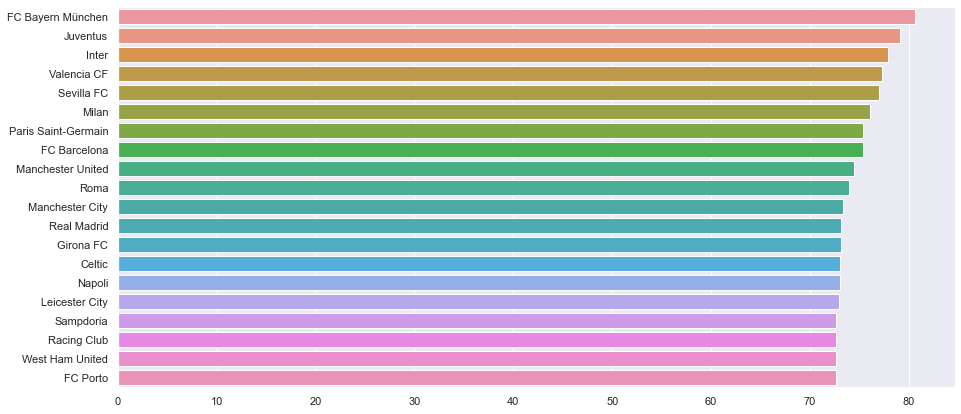

In [118]:
x=df_at.groupby('Club').agg({'Overall Attacking':'mean'})
x=x.orderBy(x['avg(Overall Attacking)'].desc())
plt.figure(figsize=(15,7))
sns.barplot(list(x.select('avg(Overall Attacking)').toPandas()['avg(Overall Attacking)'])[:20],
            list(x.select('Club').toPandas()['Club'])[:20])

### Club With Best Mid

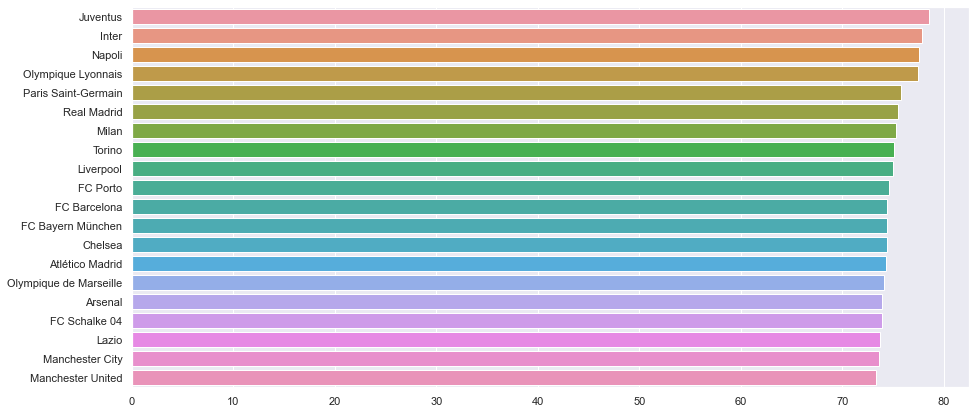

In [122]:
x=df_mid.groupby('Club').agg({'Overall Mid':'mean'})
x=x.orderBy(x['avg(Overall Mid)'].desc())
plt.figure(figsize=(15,7))
sns.barplot(list(x.select('avg(Overall Mid)').toPandas()['avg(Overall Mid)'])[:20],
            list(x.select('Club').toPandas()['Club'])[:20])

### Club With Best Defense

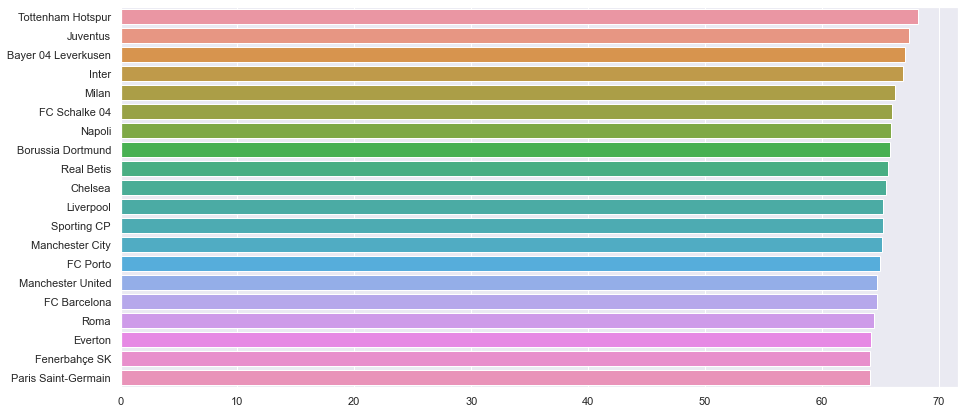

In [123]:
x=df_def.groupby('Club').agg({'Overall Defense':'mean'})
x=x.orderBy(x['avg(Overall Defense)'].desc())
plt.figure(figsize=(15,7))
sns.barplot(list(x.select('avg(Overall Defense)').toPandas()['avg(Overall Defense)'])[:20],
            list(x.select('Club').toPandas()['Club'])[:20])

In [134]:
cols=['Crossing','Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling','Curve', 'FKAccuracy', 'LongPassing', 
     'BallControl', 'Acceleration','SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower','Jumping', 'Stamina',
     'Strength', 'LongShots', 'Aggression','Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure','Marking', 
     'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling','GKKicking', 'GKPositioning', 'GKReflexes']


for col in cols:
    x=df.filter(df[col]==df.agg({col: "max"}).collect()[0][0]).select('Name').collect()[0][0]
    print(col,':',x)

Crossing : K. De Bruyne
Finishing : L. Messi
HeadingAccuracy : Naldo
ShortPassing : L. Modrić
Volleys : E. Cavani
Dribbling : L. Messi
Curve : Quaresma
FKAccuracy : L. Messi
LongPassing : T. Kroos
BallControl : L. Messi
Acceleration : Douglas Costa
SprintSpeed : K. Mbappé
Agility : Neymar Jr
Reactions : Cristiano Ronaldo
Balance : Bernard
ShotPower : Cristiano Ronaldo
Jumping : Cristiano Ronaldo
Stamina : N. Kanté
Strength : A. Akinfenwa
LongShots : L. Messi
Aggression : B. Pearson
Interceptions : N. Kanté
Positioning : Cristiano Ronaldo
Vision : L. Messi
Penalties : M. Balotelli
Composure : L. Messi
Marking : A. Barzagli
StandingTackle : G. Chiellini
SlidingTackle : Sergio Ramos
GKDiving : De Gea
GKHandling : J. Oblak
GKKicking : M. Neuer
GKPositioning : G. Buffon
GKReflexes : De Gea


<ipython-input-139-5e1262bc74fb>:15: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



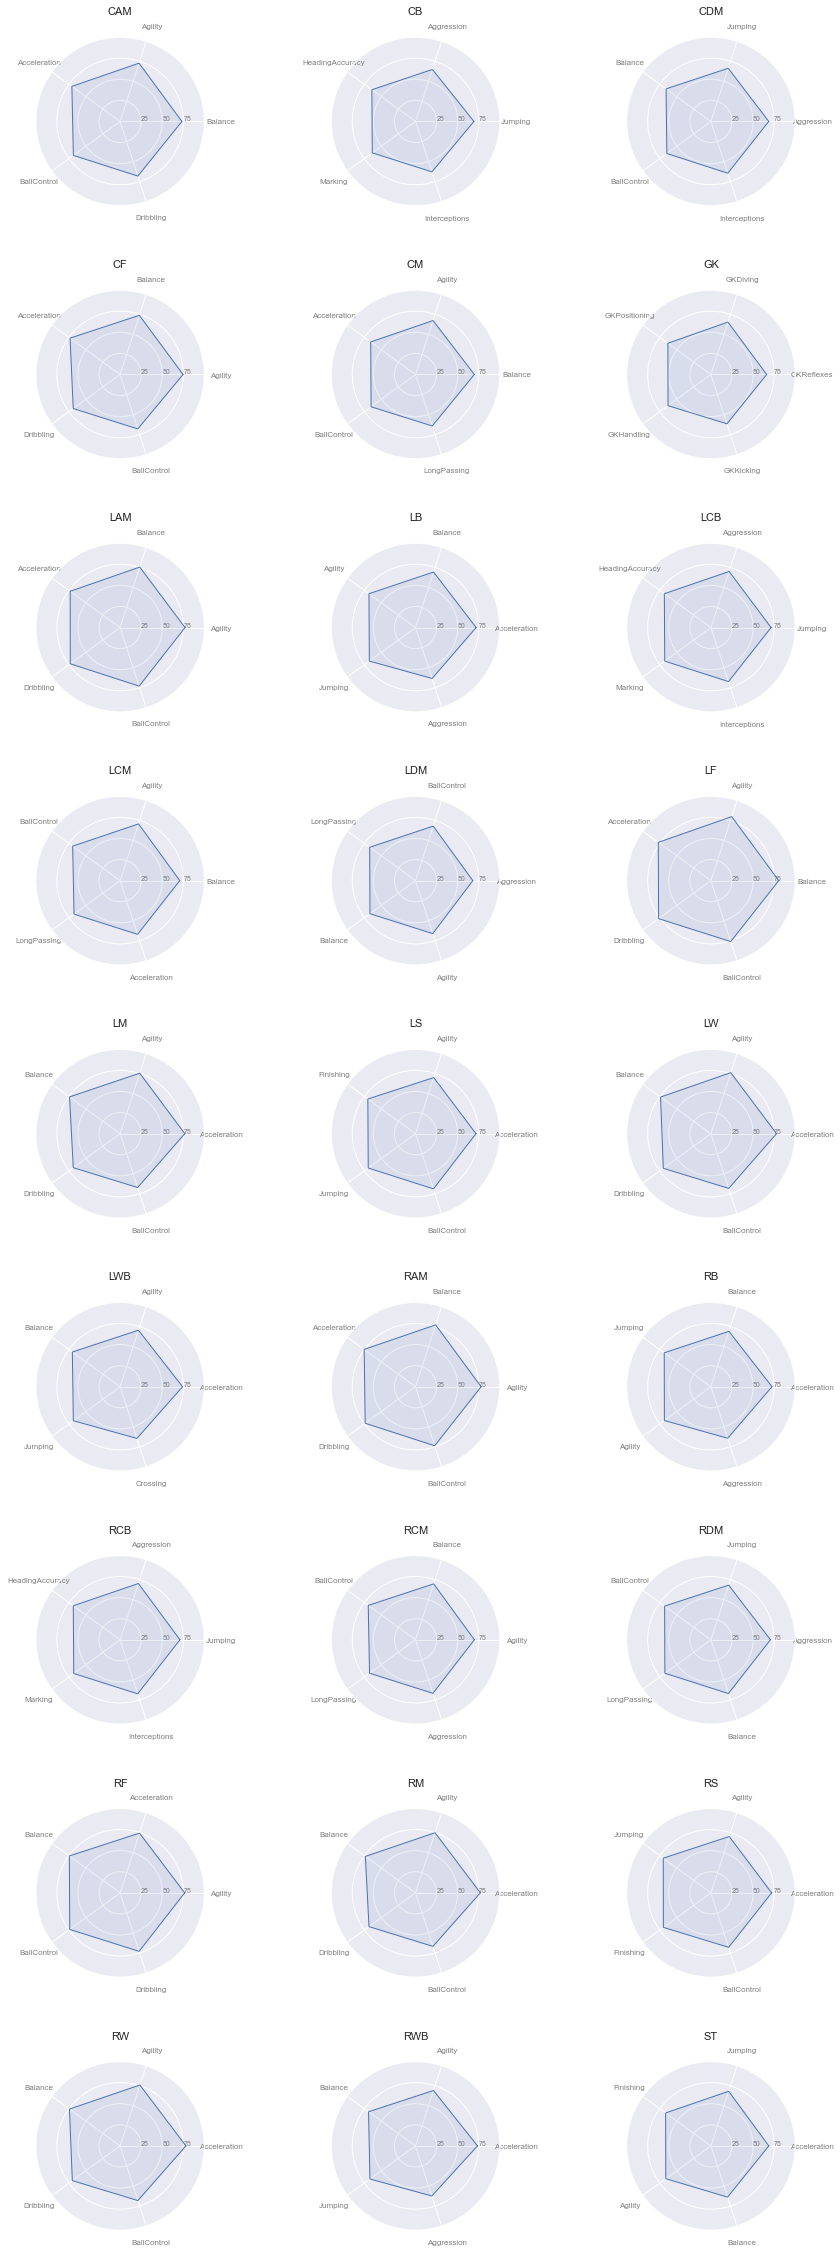

In [139]:
player_features = (
    'Acceleration', 'Aggression', 'Agility', 
    'Balance', 'BallControl', 'Composure', 
    'Crossing', 'Dribbling', 'FKAccuracy', 
    'Finishing', 'GKDiving', 'GKHandling', 
    'GKKicking', 'GKPositioning', 'GKReflexes', 
    'HeadingAccuracy', 'Interceptions', 'Jumping', 
    'LongPassing', 'LongShots', 'Marking', 'Penalties'
)
df2=pd.read_csv('data.csv')

from math import pi
idx = 1
plt.figure(figsize=(15,45))
for position_name, features in df2.groupby(df2['Position'])[player_features].mean().iterrows():
    top_features = dict(features.nlargest(5))
    
    categories=top_features.keys()
    N = len(categories)

    values = list(top_features.values())
    values += values[:1]

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(10, 3, idx, polar=True)

    
    plt.xticks(angles[:-1], categories, color='grey', size=8)
 
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7)
    plt.ylim(0,100)
    
    plt.subplots_adjust(hspace = 0.5)
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    
    plt.title(position_name, size=11, y=1.1)
    
    idx += 1

### How Age Affect Player Ability

Text(0.5, 1.0, 'Age vs GoalKeeper')

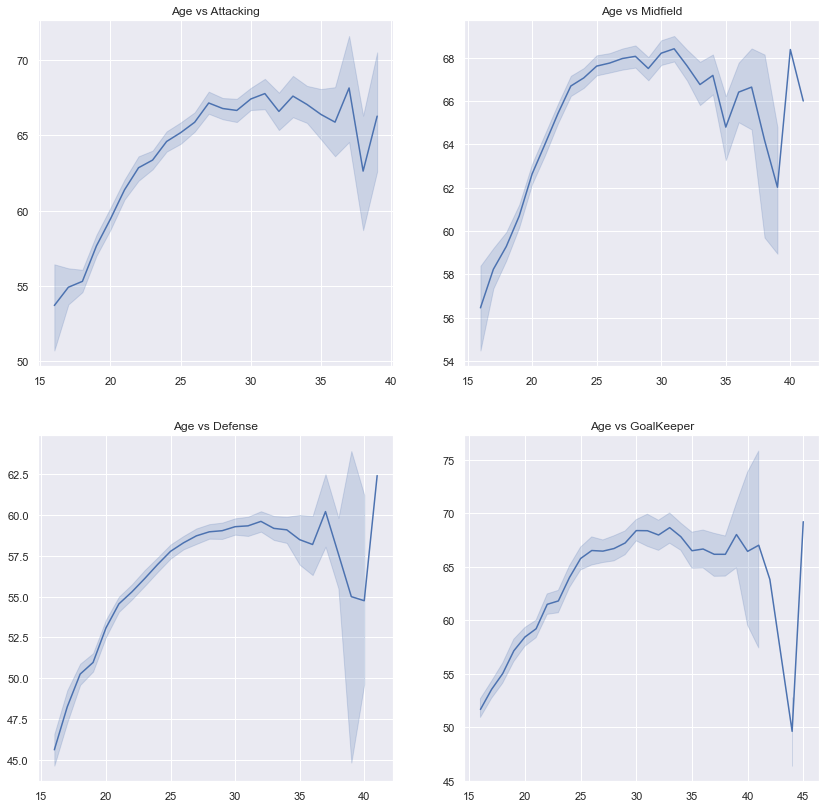

In [140]:
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(14,14))

sns.lineplot(list(df_at.select('Age').toPandas()['Age']),
             list(df_at.select('Overall Attacking').toPandas()['Overall Attacking']),ax=axes[0,0])

sns.lineplot(list(df_mid.select('Age').toPandas()['Age']),
             list(df_mid.select('Overall Mid').toPandas()['Overall Mid']),ax=axes[0,1])

sns.lineplot(list(df_def.select('Age').toPandas()['Age']),
             list(df_def.select('Overall Defense').toPandas()['Overall Defense']),ax=axes[1,0])

sns.lineplot(list(df_gk.select('Age').toPandas()['Age']),
             list(df_gk.select('Overall Goalkeeping').toPandas()['Overall Goalkeeping']),ax=axes[1,1])

axes[0,0].set_title('Age vs Attacking')
axes[0,1].set_title('Age vs Midfield')
axes[1,0].set_title('Age vs Defense')
axes[1,1].set_title('Age vs GoalKeeper')

### Players BMI Check

In [158]:
def bmi(w,h):
    
    h=h/100
    w=float(w)/2.2046
    bmi=round(w / (h * h), 2)
    
    return bmi

def bmi_cat(val):
     
    if(val<18.5):
        val_='Underweight'
    elif((val>18.5) and (val<24.9)):
        val_='Normal Weight'
    else:
        val_='Overweight'
    
    return val_

In [160]:
val_ch_bmi = udf(lambda z,y: bmi(z,y), FloatType())
spark.udf.register("val_ch_bmi", val_ch_bmi)
df=df.withColumn('BMI',val_ch_bmi('Weight','Height'))

val_ch_bmi_cat = udf(lambda z: bmi_cat(z), StringType())
spark.udf.register("val_ch_bmi_cat", val_ch_bmi_cat)
df=df.withColumn('BMI Category',val_ch_bmi_cat('BMI'))


df.select('BMI','BMI Category').show()

+-----+-------------+
|  BMI| BMI Category|
+-----+-------------+
| 24.9|   Overweight|
|23.49|Normal Weight|
|22.14|Normal Weight|
|20.46|Normal Weight|
|21.49|Normal Weight|
|24.79|Normal Weight|
| 22.2|Normal Weight|
|25.76|   Overweight|
|24.54|Normal Weight|
|24.64|Normal Weight|
|23.86|Normal Weight|
|22.78|Normal Weight|
|22.07|Normal Weight|
|22.51|Normal Weight|
|25.68|   Overweight|
|23.68|Normal Weight|
|25.15|   Overweight|
|23.76|Normal Weight|
| 24.0|Normal Weight|
| 24.5|Normal Weight|
+-----+-------------+
only showing top 20 rows



In [161]:
x=df.groupby('BMI Category').agg({'BMI Category':'count'})

data=go.Bar(
    x=list(x.select('BMI Category').toPandas()['BMI Category']),
    y=list(x.select('count(BMI Category)').toPandas()['count(BMI Category)']),
    name='BMI')

layout=go.Layout(
title='BMI',
xaxis=dict(title='Stage'),
yaxis=dict(title='Count'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

### Contracts Expiring In Future Years

In [163]:
x=df.groupby('Contract Valid Until').agg({'Contract Valid Until':'count'})
x=x.filter((x['Contract Valid Until']=='2019') | (x['Contract Valid Until']=='2020') | (x['Contract Valid Until']=='2021')
          | (x['Contract Valid Until']=='2022') | (x['Contract Valid Until']=='2023') | (x['Contract Valid Until']=='2018'))
data=go.Bar(
    x=list(x.select('Contract Valid Until').toPandas()['Contract Valid Until']),
    y=list(x.select('count(Contract Valid Until)').toPandas()['count(Contract Valid Until)']),
    name='BMI')

layout=go.Layout(
title='BMI',
xaxis=dict(title='Stage'),
yaxis=dict(title='Count'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)